In [2]:
import numpy as np
import scipy.integrate
import sdeint as sdeint

import os
from importlib import reload

from sklearn.decomposition import PCA

import sys
sys.path.append('/Users/simonfreedman/cqub/bifurc/paper_figs')
import myfun as mf


import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True) 
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches

In [11]:
def dispersion_relation(k_vals, d, mu):
    lam = np.empty_like(k_vals)
    for i, k in enumerate(k_vals):
        A = np.array([[1-d*k**2,          1],
                      [-2*mu,    -mu - k**2]])
        lam[i] = np.linalg.eigvals(A).real.max()
        
    return lam

def dispersion_eig(k_vals, d, mu):
    lam = np.zeros((k_vals.shape[0],2))
    evec = np.zeros((k_vals.shape[0],2,2))
    for i, k in enumerate(k_vals):
        A = np.array([[1-d*k**2,          1],
                      [-2*mu,    -mu - k**2]])
        w,v = np.linalg.eig(A)
        lam[i] = w.real
        evec[i] = np.abs(v)
        
    return lam, evec

In [114]:
figdir = '/Users/simonfreedman/papers/pattern/figs'

In [83]:
diff_rats = np.hstack([0.001*np.arange(1,10),0.01*np.arange(1,10), 0.1*np.arange(1,10)])
reps = np.arange(20)
datdir = '/Users/simonfreedman/data/droso/turing/noise_scales/noise1'

pattern_tf = np.array([[np.load('{0}/diff{1:.3f}_samp{2}.npy'.format(datdir, diff_rats[i], reps[j]))[:,-1] 
                        for j in range(len(reps))]
                       for i in range(len(diff_rats))])

In [84]:
ndiff, nrep, ng, ngrid = pattern_tf.shape
lscales = np.hstack([np.arange(2,10), np.arange(10,100,10),np.arange(100,300,100)])
skip    = 1 # int(w/2)
da_kbin = [np.array([[[np.mean(pattern_tf[s,j,:,k:k+w], axis=1) for k in np.arange(0,ngrid-w,w)]
                      for j in range(nrep)]
                     for s in range(ndiff)]) 
           for w in lscales]
ncomp = np.array([x.shape[2] for x in da_kbin])

#[x.shape for x in da_kbin]
# da_kbin[i][j,k,l,m] is the i^th length scale
#                        the j^th diffusion ratio (or distance from MF)
#                        the k^th replicate
#                        the l^th bin
#                        the m^th gene avgd over every position in the bin

In [85]:
# kbin_pcas = np.array([[[PCA().fit(kbin_samps_f[i,j,k]) 
#                         for k in range(nrepsamp)] 
#                        for j in range(ndiff)]
#                       for i in range(len(lscales))])
kbin_pcas = np.array([[[PCA().fit(da_kbin[k][s,i]) for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])

In [86]:
da_kbin_evecs = np.array([[[kbin_pcas[k,s,i].components_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])
da_kbin_evals = np.array([[[kbin_pcas[k,s,i].explained_variance_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])
da_kbin_eval_rats = np.array([[[kbin_pcas[k,s,i].explained_variance_ratio_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])


In [87]:
L = 20.0
kvals     = np.pi * ngrid / (lscales * L)
rxn_params = (1.5,)

disp_pca  = [dispersion_eig(kvals, d, rxn_params[0]) for d in diff_rats]

disp_eig  = np.array([d[0] for d in disp_pca])
disp_evec = np.array([d[1] for d in disp_pca])


disp_max_eig_idx = np.argmax(disp_eig, axis=2)
disp_max_eig     = np.amax(disp_eig, axis=2)
disp_max_evec    = np.array([[disp_evec[i,j,:,disp_max_eig_idx[i,j]] for j in range(disp_evec.shape[1])] 
                     for i in range(disp_evec.shape[0])]).transpose((1,0,2))

disps            = np.array([dispersion_relation(kvals, d, rxn_params[0]) for d in diff_rats])
has_pattern      = np.amax(1/disps, axis=1)>0

In [88]:
da_kbin_evals_mu = np.mean(da_kbin_evals,axis=2)
da_kbin_max_evec = da_kbin_evecs[:,:,:,0]
#da_kbin_evec_mu  = np.mean(da_kbin_max_evec,axis=2)
evec_errs        = np.linalg.norm(da_kbin_max_evec.transpose((2,0,1,3)) - disp_max_evec,axis=3)
evec_err_mu      = np.mean(evec_errs,axis=0)

In [89]:
evec_errs.shape

(20, 19, 27)

In [90]:
pattern_k = kvals[np.array([np.argmax(x) for x in disp_max_eig])]

In [91]:
onset_drat_idx = np.where(np.diff(has_pattern))[0][0]
onset_k_idx    = np.where(disps[onset_drat_idx]>0)[0][0]

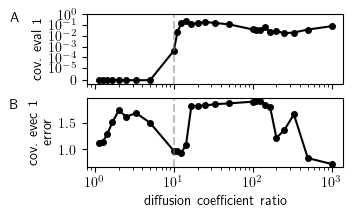

In [117]:
wid = 8.4/2.54
fig,axs = plt.subplots(2,1,figsize=(wid,wid*0.6))

k_idx = onset_k_idx
axs[0].plot(1/diff_rats,da_kbin_evals_mu[k_idx,:,0],'ko-',markersize=4)
axs[1].plot(1/diff_rats,evec_err_mu[k_idx],'ko-',markersize=4)

for ax in axs:
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.axvline(1/diff_rats[onset_drat_idx],alpha=0.5,color='gray',ls='--')
    #ax.set_xlim(1,100)
axs[0].set_yscale('symlog', linthresh=1e-5)
axs[0].set_ylim(ymin=-3e-6,ymax=1)
axs[1].set_xlabel('diffusion coefficient ratio')
axs[0].set_ylabel('cov. eval 1')
axs[1].set_ylabel('cov. evec 1\nerror')
plt.subplots_adjust(hspace=0.2)
axs[0].set_xticklabels([])

axs[0].text(x=-0.3,y=0.9,s='A',transform=axs[0].transAxes)
axs[1].text(x=-0.3,y=0.85,s='B',transform=axs[1].transAxes)

plt.savefig('{0}/asdm_noise1_cov.pdf'.format(figdir),bbox_inches='tight')
plt.show()


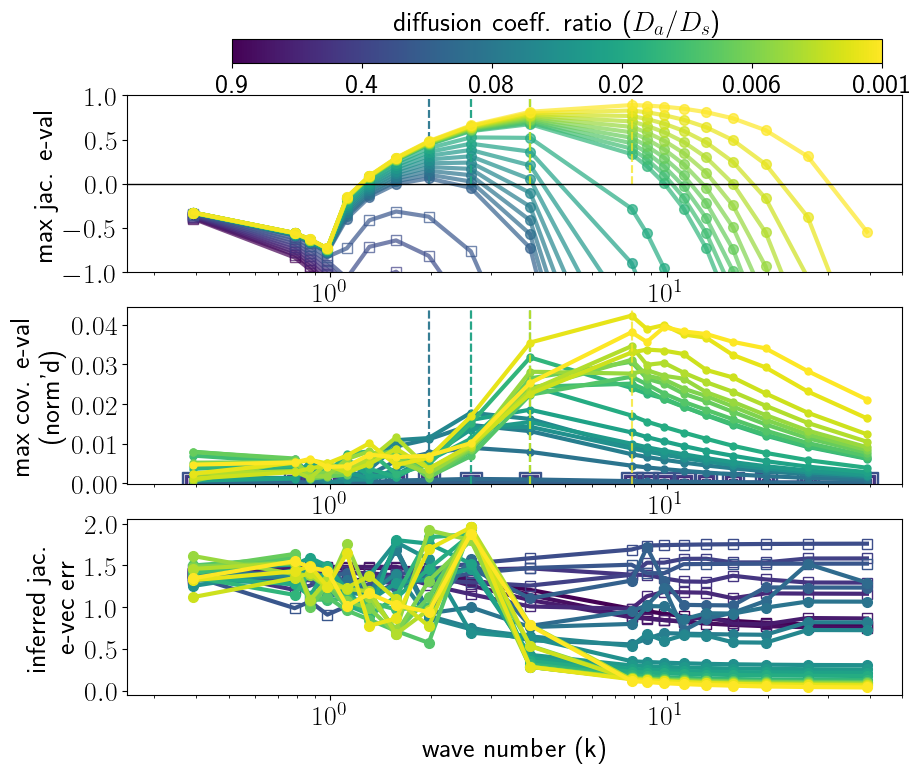

In [16]:
fig,axs = plt.subplots(3,1,figsize=(10,8))
cols    = plt.cm.viridis_r(np.linspace(0,1,ndiff))
marks   = ['o' if has_pattern[i] else 's' for i in range(ndiff)]
fills   = ['full' if has_pattern[i] else 'none' for i in range(ndiff)]
msizes  = [5 if has_pattern[i] else 2*(ndiff - i) for i in range(ndiff)]

norm = 1/ncomp #np.ones_like(ncomp) #ncomp
for i in range(ndiff-1,-1,-1):
    
    
    axs[0].plot(kvals, disp_max_eig[i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=0.7, markersize=7, lw=3)
    axs[1].plot(kvals, da_kbin_evals_mu[:,i,0]*norm, '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=1, markersize=msizes[i], lw=3)
    axs[2].plot(kvals, evec_err_mu[:,i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=1, markersize=7, lw=3)
    
    if has_pattern[i]:
        axs[0].axvline(pattern_k[i], ymin=0.5,color=cols[i], linestyle='--', alpha=0.5)
        axs[1].axvline(pattern_k[i], ymin=0,color=cols[i], linestyle='--', alpha=0.5)
    
for ax in axs:
    ax.set_xscale('log')

#axs[1].set_yscale('symlog',linthresh=1e-3)
axs[1].set_ylim(ymin=-1e-4)


axs[2].set_xlabel('wave number (k)')
axs[0].set_ylabel('max jac. e-val')
axs[1].set_ylabel('max cov. e-val\n(norm\'d)')
axs[2].set_ylabel('inferred jac.\ne-vec err')
axs[0].set_ylim(-1, 1)


axs[0].axhline(0,color='k',lw=1)
fsz=20
for ax in axs: #[axs[0], axs[1], cax]
    ax.set_xlim(0.25,50)
    mf.set_axs_fontsize(ax, fsz)

my_cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=0))
#plt.subplots_adjust(bottom=0.1, right=0.9, top=0.85)
#cax = plt.axes([0.91, 0.1, 0.02, 0.8])
#cbar = plt.colorbar(sm, cax=cax)

plt.subplots_adjust(top=0.86)
cax = plt.axes([0.23, 0.9, 0.65, 0.03])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
ctix = np.linspace(0,1,6)
cbar.set_ticks(ctix)
cbar.set_ticklabels(np.hstack([diff_rats[np.array(ctix[0:-1]*ndiff, dtype='int')], diff_rats[-1]]))
cbar.set_ticklabels(np.hstack([diff_rats[-1],diff_rats[np.array(ctix[-2::-1]*ndiff, dtype='int')]]))

#cbar.set_label(r'diffusion coeff. ratio ($D_a/D_s$)',rotation = 270, labelpad = 15)
cbar.set_label(r'diffusion coeff. ratio ($D_a/D_s$)',rotation = 0, labelpad = 7)
cbar.ax.xaxis.set_label_position('top')

#cbar.set_label_position('top') 



mf.set_axs_fontsize(cax, fsz)
plt.show()


In [5]:
# # same number of bins at every kscale
# nlscale   = len(lscales)
# ngene     = 2
# samp_size = 100
# nsamp     = 15
# nbin    = 10  
# da_kbins = [np.array([[[pattern_tf[s,j,:,k:k+w] for k in np.arange(0,ngrid-w,1)] 
#               for j in range(nrep)]
#              for s in range(ndiff)])
#             for w in lscales]

# [x.shape for x in da_kbins] 
# da_kbins[i][j,k,l,m,n] is the i^th length scale
#                           the j^th diffusion ratio (or distance from MF)
#                           the k^th replicate
#                           the l^th bin
#                           the m^th gene
#                           the n^th position along the bin

In [9]:

# samp_idxs = [np.random.choice(ncomp[i], size = [ndiff, nrep, nsamp, samp_size],replace=True) 
#              for i in range(len(lscales))]
# kbin_samps = np.array([[[da_kbin[i][j,k,samp_idxs[i][j,k]] for k in range(nrep)]
#                         for j in range(ndiff)]
#                        for i in range(nlscale)])
# kbin_samps.shape

# kbin_samps[i,j,k,l,m,n] is the i^th length scale
#                            the j^th diffusion ratio (distance from MF)
#                            the k^th replicate
#                            the l^th sample
#                            the m^th sample of the sample
#                            the n^th gene


# flatten along k / l

# kbin_samps_f = kbin_samps.reshape((nlscale,ndiff, nrep*nsamp, samp_size, ngene))
# kbin_samps_f.shape


# kbin_samps_f[i,j,k,l,m] is the i^th length scale
#                            the j^th diffusion ratio (distance from MF)
#                            the k^th sample
#                            the l^th sample of the sample
#                            the m^th gene

# nrepsamp = nrep*nsamp

In [10]:
# to test reshaping....
# i = 0
# j = 0
# np.array_equal(kbin_samps_f[i,j,16], kbin_samps[i,j,1,1])
# np.sum(~np.array([[[[np.array_equal(kbin_samps_f[i,j,k*nsamp+l], kbin_samps[i,j,k,l]) 
#               for l in range(nsamp)] 
#              for k in range(nrep)]
#             for j in range(ndiff)]
#            for i in range(nlscale)])) # should be 0

In [13]:
# da_kbin_norms = [np.array([[sinkhorn_norm(da_kbin[k][s,i], max_iter = 100, err=1e-100, out_iter=100) 
#                  for i in np.arange(da_kbin[k].shape[1])]
#                  for s in np.arange(da_kbin[k].shape[0])])
#                  for k in np.arange(len(lscales))]

In [14]:
# kbin_pcas = np.array([[[PCA().fit(da_kbin_norms[k][s,i]) for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
# da_kbin_evecs = np.array([[[kbin_pcas[k,s,i].components_ for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
# da_kbin_evals = np.array([[[kbin_pcas[k,s,i].explained_variance_ for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
# da_kbin_eval_rats = np.array([[[kbin_pcas[k,s,i].explained_variance_ratio_ for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
